<a href="https://colab.research.google.com/github/ujjwalbb30/Ujjwal_DATA606/blob/main/notebooks/Step_1_Data_Preparation_Ujjwal_PF10610.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DATA 606 : Capstone Project**
##**Course Instructor: Dr. Chaojie Wang**
>**Data Science Department**

>**University of Maryland, Baltimore County**

###**Submitted By: Ujjwal**
>**UMBC ID: PF10610**

##**Data Preparation**

First, I will prepare a dataframe with all textual and image features.

###**Installing Required Libraries**

In [ ]:
# installing pytessaract and tessaract OCR for reading texts from images
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
# installing tweet-preprocessor for text cleaning
!pip install tweet-preprocessor

In [ ]:
# installing tqdm and progressbar
!pip install progressbar
!pip install tqdm

###**Importing Required Libraries**

In [ ]:
# importing required dependencies

# importing pandas, numpy, random, matplotlib and their required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

# importing other required libraries
import glob
import cv2
import skimage
from skimage.transform import resize
import gc
from progressbar import ProgressBar
from tqdm.notebook import tqdm_notebook
import pytesseract
import shutil
import os
import random
try:
  from PIL import Image
except ImportError:
  import Image

###**Mounting the Drive and Copying the Data from Drive to Colab assigned machine**

From my previous experience, I have observed that copying the data to assigned colab machine helps in faster processing

In [ ]:
# mounting the drive to access data files
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# defining the path of data in drive (path to copy the data from)
# defining the path where the data should be copied

drive_path = '/content/gdrive/MyDrive/DATA_606_Capstone_Project_Ujjwal/Dataset'
local_path = '/content'

# copying the data from drive to machine
!cp -av '/content/gdrive/MyDrive/DATA_606_Capstone_Project_Ujjwal/Dataset' '/content'

###**Viewing Sample Images**

In [ ]:
# extracting text from a sample image to verify if the OCR is working
sample_image_path = '/content/Dataset/Email/2064207054c.jpg'
sample_extracted_text = pytesseract.image_to_string(Image.open(sample_image_path))

In [ ]:
# viewing the extracted text from sample image
print('text from sample image is:\n',sample_extracted_text)
print('\nchecking the type of text extracted:\n',type(sample_extracted_text))

text from sample image is:
 Pabst, Joanne

 

From: Keane, Denise

Sent: Tuesday, March 09, 1999 1:14 PM
Ta: Bertind, Mark

Subject: FDA

did you see the Jeff Richmond advocacy piece before it was sent to the wro. if you didn't | intend to call a&p, as |
do not want them preparing such pieces unless we see them first.

IPSOLOTP90T


checking the type of text extracted:
 <class 'str'>


In [ ]:
# Preparing a dataset with all image labels and path

# defining the path to all images data folder
img_data_folder = '/content/Dataset'

# initializing an empty list to store paths and labels of images
img_data = []

# saving images' paths and labels
for folder in os.listdir(img_data_folder):
    label_folder = os.path.join(img_data_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    img_data += onlyfiles

# creating a dataframe from the list created
img_data_df = pd.DataFrame(img_data)

# viewing the details of all images dataframe
print('Images Data:\n')
display(img_data_df)
print('\nunique labels:\n',img_data_df['label'].unique())
print('\n number of unique labels:\n',img_data_df['label'].nunique())
print('\nnumber of instances for each label:\n',img_data_df['label'].value_counts())

Images Data:



,label,path
0,Note,/content/Dataset/Note/2073440248.jpg
1,Note,/content/Dataset/Note/2048858141.jpg
2,Note,/content/Dataset/Note/10384492.jpg
3,Note,/content/Dataset/Note/71460901.jpg
4,Note,/content/Dataset/Note/1003403894_1003403895.jpg
...,...,...
3487,Report,/content/Dataset/Report/507963083_507963090.jpg
3488,Report,/content/Dataset/Report/507767713_507767722.jpg
3489,Report,/content/Dataset/Report/507745286_507745288.jpg
3490,Report,/content/Dataset/Report/510907182_510907183.jpg



unique labels:
 ['Note' 'Form' 'Email' 'Letter' 'News' 'ADVE' 'Memo' 'Resume' 'Scientific'
 'Report']

 number of unique labels:
 10

number of instances for each label:
 Memo          621
Email         600
Letter        568
Form          432
Report        266
Scientific    262
ADVE          231
Note          202
News          189
Resume        121
Name: label, dtype: int64


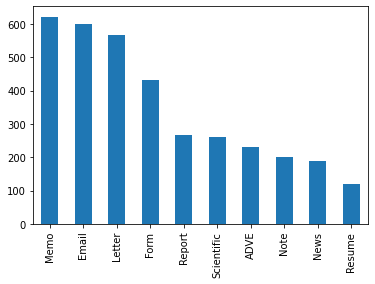

In [ ]:
# viewing the distribution of instances
img_data_df['label'].value_counts().plot(kind='bar')

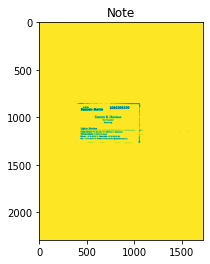

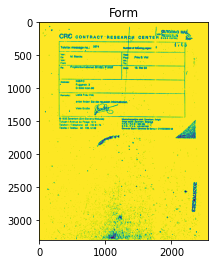

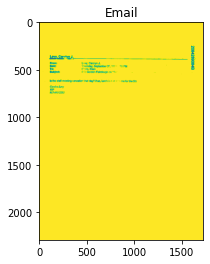

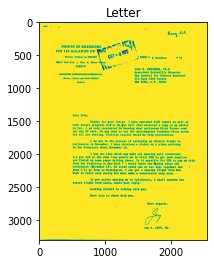

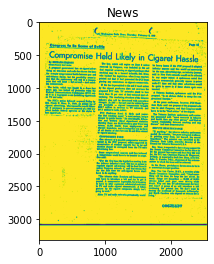

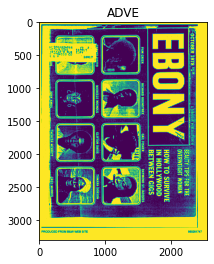

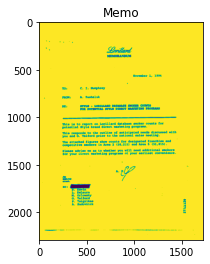

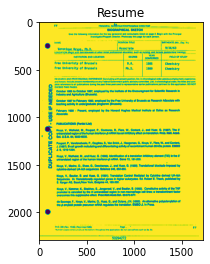

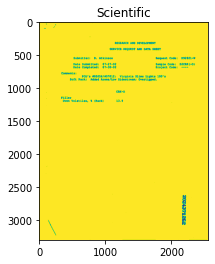

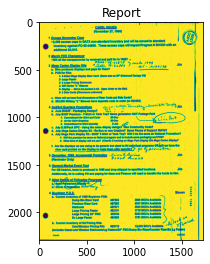

In [ ]:
# viewing random images of each label

doc_imgs = img_data_df['label'].unique().tolist()
images = []

for doc_image in doc_imgs:
    rows = img_data_df[img_data_df['label']==doc_image]['path']
    random_doc = random.randint(a=0, b=len(rows))
    filepath = rows.iloc[random_doc]
    img = mpimg.imread(filepath)
    plt.figure()
    plt.title(doc_image)
    plt.imshow(img)

###**Reading texts from images and saving them as associated textual features**

In [ ]:
# defining a list of 'labels' to iterate over
doc_labels = list(img_data_df['label'].unique())
print(doc_labels)

['Note', 'Form', 'Email', 'Letter', 'News', 'ADVE', 'Memo', 'Resume', 'Scientific', 'Report']


In [ ]:
# extracting text from all the images label wise and saving different dataframe for each
# it will help in tracking and making amends in case the iteration gets disrupted due to some technical issue

for label in tqdm_notebook(doc_labels, desc='Label Loop (loop 1)'):
  # initializing an empty list
  doc_labels = []

  # getting the dataframe of interest
  doc_labels_df = img_data_df[img_data_df['label']==label].copy()

  # looping over each row of the retrieved dataframe to extract the text
  for index, row in tqdm_notebook(doc_labels_df.iterrows(), total=doc_labels_df.shape[0], desc=label+' Loop'):
    if row['path'] == '/content/Dataset/'+label+'/Thumbs.db':
      doc_labels.append('None')
    else:
      doc_labels.append(pytesseract.image_to_string(Image.open(row['path'])))
  
  # adding the retrieved text as another column in dataframe
  doc_labels_df['text'] = doc_labels

  # displaying the content of the final dataframe
  print('For '+ label+':\n')
  display(doc_labels_df)

  # exporting the dataframe
  doc_labels_df.to_csv('/content/gdrive/MyDrive/DATA_606_Capstone_Project_Ujjwal/Data_1/'+label+'.csv', index=False)

Label Loop (loop 1):   0%|          | 0/10 [00:00<?, ?it/s]

Note Loop:   0%|          | 0/202 [00:00<?, ?it/s]

For Note:



,label,path,text
0,Note,/content/Dataset/Note/2073440248.jpg,\n\nARTHUR C. PADOAN\n\nerz0rVyelo?\n\nIV G7 ...
1,Note,/content/Dataset/Note/2048858141.jpg,et ao\n\ncacgion Cas PY Heap\n\n \n\n \n\n \n\...
2,Note,/content/Dataset/Note/10384492.jpg,\n\n_ PPD AY pid Be\n\n7 Cane CO cirneten PP ...
3,Note,/content/Dataset/Note/71460901.jpg,190242521\n\nPRODUC]\n\n \n\nED FROM\n\nB&W WE...
4,Note,/content/Dataset/Note/1003403894_1003403895.jpg,\n\n \n\n \n\n \n\n \n\nof .\n\nSLZESE STUP...
...,...,...,...
197,Note,/content/Dataset/Note/2012517041.jpg,wee ey ee\n\nDAVE PRESTON\n\n \n\n‘CHICAGO ...
198,Note,/content/Dataset/Note/2071191029.jpg,2071191029\n\n \n\nFOR YOUR INFORMATION\nJOE M...
199,Note,/content/Dataset/Note/88025179.jpg,ra 6 995°\n\nMemo from ARTHUR J. steven?\nWSeg...
200,Note,/content/Dataset/Note/2075949750.jpg,all 3 som ele. = 4a\n\nFT Z.0\n\nLo pate or ne...


Form Loop:   0%|          | 0/432 [00:00<?, ?it/s]

For Form:



,label,path,text
202,Form,/content/Dataset/Form/2505402423.jpg,\n\nINBIFO Institut fir biologische Forschung...
203,Form,/content/Dataset/Form/2020129373.jpg,yi mt OF\n\n“Form 3 (9/77) PM #\nPhilip: Morri...
204,Form,/content/Dataset/Form/2086082866.jpg,Je ]=28-00 11:38am From-LONGVIEW NEWS RETAIL 9...
205,Form,/content/Dataset/Form/2023130835.jpg,eS ede PE SSeZ0 19 1 RAGA GB RE ESATO SP IRENE...
206,Form,/content/Dataset/Form/2040118863.jpg,treonees ssasesseneonsescansssestesesssronanee...
...,...,...,...
629,Form,/content/Dataset/Form/2505117113_7119.jpg,\n\nCRC contRact RESEARCH CENTER\n\n \n...
630,Form,/content/Dataset/Form/508851993+-1993.jpg,+ BY? Form 1484 Rav. 6/77\n\nREQUEST FOR GRATI...
631,Form,/content/Dataset/Form/505857485.jpg,\n\nA) fp eh Ont fa of FEF\n\nNPT SENSORY TES...
632,Form,/content/Dataset/Form/2075461961.jpg,a\nMi OMAY-04-088 (16:87 FROW-LINDSAY HART 503...


Email Loop:   0%|          | 0/600 [00:00<?, ?it/s]

For Email:



,label,path,text
634,Email,/content/Dataset/Email/2083432603a.jpg,"\n\n—~-Original Message-----\n\nFrom: Yates, ..."
635,Email,/content/Dataset/Email/2078868519.jpg,2078868519\n\nimmense Original Message-----\nF...
636,Email,/content/Dataset/Email/2078434728.jpg,"From: Woodson, Beverley C.\n\nSent: Thursday, ..."
637,Email,/content/Dataset/Email/2071863501a.jpg,"Chaikin, Karen\n\n \n\nFrom: Chaikin, Karen\n\..."
638,Email,/content/Dataset/Email/2085272616a.jpg,"— Original Message----~\n\nFrom: Mathew, Aleya..."
...,...,...,...
1229,Email,/content/Dataset/Email/528803013+-3014.jpg,RJRO000000507030726\n70047 1080\n\nFrom: Reavi...
1230,Email,/content/Dataset/Email/2085111504a.jpg,"-----Original Message-——\n\nFrom: Femandez, He..."
1231,Email,/content/Dataset/Email/2085800016d.jpg,"\n \n\nFrom: — Pfeil, Michael £.\nSent: Tues..."
1232,Email,/content/Dataset/Email/2084391924.jpg,2084391924\n\n——— Original Message-----\n\nFro...


Letter Loop:   0%|          | 0/568 [00:00<?, ?it/s]

For Letter:



,label,path,text
1234,Letter,/content/Dataset/Letter/508407516_508407518.jpg,\n\nTO: JERRY W. LAWSON\n\nWKO11591\nFROM: K....
1235,Letter,/content/Dataset/Letter/507724696.jpg,\n\n \n\nR.j.Reynolds/M.C. Tobacco Company. L...
1236,Letter,/content/Dataset/Letter/11019361.jpg,pe\n\n \n\nref.\n\nINSTITUTE FOR MARINE ENVIRO...
1237,Letter,/content/Dataset/Letter/ton01402.63_ton01402.6...,"\n\nOQ: BR, FRARK DEYDER FROM: ERREST PRPPLES..."
1238,Letter,/content/Dataset/Letter/50375676-5676.jpg,"<\n\nTHE COUNCIL FOR TOBACCO RESEARCH-U.S.A., ..."
...,...,...,...
1797,Letter,/content/Dataset/Letter/00000831.jpg,Letter to the Editor of Personnel Administrato...
1798,Letter,/content/Dataset/Letter/524237789+-7789.jpg,\n\nACTION ON SMOKING AND HEALTH\n\n2013 H ...
1799,Letter,/content/Dataset/Letter/50437836-7836.jpg,"THE Counci, For Tonacco Resrarci~U.S.A., Inc.\..."
1800,Letter,/content/Dataset/Letter/tob02711.67.jpg,\n\n- : ot Yj af | pases 7\nfo OO. :\n\nARTHU...


News Loop:   0%|          | 0/189 [00:00<?, ?it/s]

For News:



,label,path,text
1802,News,/content/Dataset/News/2083779691.jpg,a\nBRENTON HERALD\nBRAGENTON. FL.\nCIRC-(4)4@ ...
1803,News,/content/Dataset/News/87023168_3169.jpg,ry Smoke —\n\n \n \n\nent nt li\n\neV A a ag...
1804,News,/content/Dataset/News/1003044360-a.jpg,{COZOUY A%6\n\neo\n\nNEw YORK: TIMES.\nNew Yor...
1805,News,/content/Dataset/News/2010030882.jpg,"WHOLESALE TOBACCO DISTRIBUTORS OF NEW YORK, In..."
1806,News,/content/Dataset/News/10031067.jpg,"THe WALL STREET JOURNAL\nNew York, New York\nA..."
...,...,...,...
1986,News,/content/Dataset/News/2025880123.jpg,AEMAUA IRLOCUUr ICR\n\nBURFELLE’S\n\ne790 >\n\...
1987,News,/content/Dataset/News/03747860.jpg,\n \n \n \n \n \n \n ...
1988,News,/content/Dataset/News/2070877098.jpg,IMAGE\nNOT\nAVAILABLE\nONLINE\n\nThe material ...
1989,News,/content/Dataset/News/2057077308.jpg,\n\n \n\nADVERTISING\n\n \n\nPlans an Attack’...


ADVE Loop:   0%|          | 0/231 [00:00<?, ?it/s]

For ADVE:



,label,path,text
1991,ADVE,/content/Dataset/ADVE/2041089398.jpg,2041089398\n\nI\n\n \n\n \n\n‘ST wey] ‘SIX ...
1992,ADVE,/content/Dataset/ADVE/03567810.jpg,"\n\nTHT Wy TY\n\n~ @1S@] an,\n\nGBnoI Hea ADO..."
1993,ADVE,/content/Dataset/ADVE/12320856.jpg,Exner &: CMrcaaine vetson) “ At's Bact ’\n\nAA...
1994,ADVE,/content/Dataset/ADVE/509130720+-0721.jpg,\n\n \n\nBE reed\n\n \n\nOWA Wiis.\n\nSE...
1995,ADVE,/content/Dataset/ADVE/502596443.jpg,\n \n \n \n \n \n \n \n \n \n \n \n \n \n ...
...,...,...,...
2217,ADVE,/content/Dataset/ADVE/71895703.jpg,\n\nlast rough.pu\nele mee) ni( =e\nthe s...
2218,ADVE,/content/Dataset/ADVE/91656417.jpg,| Prefer\n\n \n\nThieves\n\n \n\nPontiac\...
2219,ADVE,/content/Dataset/ADVE/13581913.jpg,Rest RELESS\nMR\n\nCeO See ECR) SUB LeR UL) a\...
2220,ADVE,/content/Dataset/ADVE/517950663+-0671.jpg,51795 @663\n\nd6f (N04 TNL Nt ORGAN\n48¥ly TWO...


Memo Loop:   0%|          | 0/621 [00:00<?, ?it/s]

For Memo:



,label,path,text
2222,Memo,/content/Dataset/Memo/2072607314_7316.jpg,PHILIP MORRIS MANAGEMENT CORP. INTER-OFFICE CO...
2223,Memo,/content/Dataset/Memo/2061639550.jpg,\n\nDate: 9/20/96\n\nTo: CD Rom Customer Serv...
2224,Memo,/content/Dataset/Memo/2074123192.jpg,To:\n\nFrom:\n\nSubject:\n\nCaron)\n\nPHILIP M...
2225,Memo,/content/Dataset/Memo/1002977842_1002977847.jpg,"\n\n“RICHMOND, VIRGINIA\n\n \n \n \n ..."
2226,Memo,/content/Dataset/Memo/2051691699_2051691700.jpg,PHILIP MORRIS COMPANIES INC. INTER-OFFICE CORR...
...,...,...,...
2838,Memo,/content/Dataset/Memo/85026674_85026676.jpg,"\n\nLervdard\n\n \n\nMEMORANDUM\nAugust 6, 19..."
2839,Memo,/content/Dataset/Memo/98215328_5336.jpg,Lull COMPANY\n\nMEMORANDUM\n\nTO: G. Baroody G...
2840,Memo,/content/Dataset/Memo/2051575345_2051575346.jpg,\n\nPHILIP MORRIS U.S. A.\nINTER-OFFICE CORRE...
2841,Memo,/content/Dataset/Memo/01390279.jpg,"rey\n\n. a\n\nMEMORANDUM\nJanuary 22,\n\nTO: M..."


Resume Loop:   0%|          | 0/121 [00:00<?, ?it/s]

For Resume:



,label,path,text
2843,Resume,/content/Dataset/Resume/50509820-9820.jpg,FI Prnicipal Investigator‘Program Director ‘La...
2844,Resume,/content/Dataset/Resume/50515818-5819.jpg,FF Principat Investigator/Pragram Director (La...
2845,Resume,/content/Dataset/Resume/40010133-0134.jpg,\n\nName: Mauricio A. GONZALEZ\n\nBirth Date:...
2846,Resume,/content/Dataset/Resume/50441969-1970.jpg,\n\nPRINCIPAL (NVESTIGATCAVPROGAAM DIRECTOR...
2847,Resume,/content/Dataset/Resume/50371016-1016.jpg,FF Principal Investigator/Program Director (La...
...,...,...,...
2959,Resume,/content/Dataset/Resume/50501854-1854.jpg,FF PRINCIPAL INVESTIGATORIPROGRAM DIRECTOR:\nB...
2960,Resume,/content/Dataset/Resume/50357861-7862.jpg,\n\ni GRANT NUMBER:\n\nBIOGRAPHICAL SKETCH\n\...
2961,Resume,/content/Dataset/Resume/50638712-8712.jpg,FF Principal Investigator/Program Director (La...
2962,Resume,/content/Dataset/Resume/50513847-3848.jpg,FF Principal Investigalor/Program Director (La...


Scientific Loop:   0%|          | 0/262 [00:00<?, ?it/s]

For Scientific:



,label,path,text
2964,Scientific,/content/Dataset/Scientific/50538109-8115.jpg,Role of myosin light-chain phosphorylation in ...
2965,Scientific,/content/Dataset/Scientific/1003112789_1003112...,* . c: at 8 - Appendix I!\n\n \n\nA NEW METHO...
2966,Scientific,/content/Dataset/Scientific/501060341+-0350.jpg,"\n\naa 5, . dea Ahk eat ain en watts mas hint..."
2967,Scientific,/content/Dataset/Scientific/2028840914.jpg,Dr. T.S. Osdene\n\nDirector of Research\n\nand...
2968,Scientific,/content/Dataset/Scientific/PUBLICATIONS040939...,"- 1990 ANNUAL REPOR)\n\n-_, Carcinogenesis vot..."
...,...,...,...
3221,Scientific,/content/Dataset/Scientific/2028875721.jpg,PAGE 0\nDe. W. Fink\nVice Director Research\nF...
3222,Scientific,/content/Dataset/Scientific/50546182-6182.jpg,Journal af Cardiovascular Pharmacologe™\n\n29:...
3223,Scientific,/content/Dataset/Scientific/2023129971.jpg,Fag ag ech atte WAREIS PRIS EOI ESL GRA HOM CL...
3224,Scientific,/content/Dataset/Scientific/1001402452_2454.jpg,CHARGE NUMBER: 6906\n\nPROGRAM TITLE: BIOLOGIC...


Report Loop:   0%|          | 0/266 [00:00<?, ?it/s]

For Report:



,label,path,text
3226,Report,/content/Dataset/Report/522629373+-9373.jpg,Amy -~ here are a few thoughts. If you would l...
3227,Report,/content/Dataset/Report/50027604_50027607.jpg,‘\nLeer\n\nTITLE OF RESEARCH PROJECT:\nTHE COM...
3228,Report,/content/Dataset/Report/24010243_24010244.jpg,XEROX TELECOPIER 295 ; 11- 1-89; 2:27 PM: 217 ...
3229,Report,/content/Dataset/Report/524257370+-7371.jpg,Status\n12/17/98\n\nEclipse\n\nCurrent / Futur...
3230,Report,/content/Dataset/Report/505127415_505127418.jpg,\n\nAuthor: Carol R. Miller Dates: August 11...
...,...,...,...
3487,Report,/content/Dataset/Report/507963083_507963090.jpg,104\n\nDr. Rainer Wendeborn/Thomas Leutner\nRH...
3488,Report,/content/Dataset/Report/507767713_507767722.jpg,\n\n \n\nSPECIAL PUBLIC RELATIONS PROGRAMS\n\...
3489,Report,/content/Dataset/Report/507745286_507745288.jpg,"\n\n \n\n \n\n& Tobacco Company Cot, Me ..."
3490,Report,/content/Dataset/Report/510907182_510907183.jpg,MARYLAND TOBACCO\n4 .\n\nSOUTHERN MARYLAND TOB...


##**Importing the prepared .csv files of each label**

In [ ]:
# preparing a list of paths for all the .csv files

# getting the path of the directory hosting all the .csv files
final_csv_path = '/content/gdrive/MyDrive/DATA_606_Capstone_Project_Ujjwal/Data_1/'

# retrieving and viewing the paths of all the .csv files
final_csvs = glob.glob(final_csv_path+"*.csv")
display(final_csvs)

['/content/gdrive/MyDrive/DATA_606_Capstone_Project_Ujjwal/Data_1/Note.csv',
 '/content/gdrive/MyDrive/DATA_606_Capstone_Project_Ujjwal/Data_1/Form.csv',
 '/content/gdrive/MyDrive/DATA_606_Capstone_Project_Ujjwal/Data_1/Email.csv',
 '/content/gdrive/MyDrive/DATA_606_Capstone_Project_Ujjwal/Data_1/Letter.csv',
 '/content/gdrive/MyDrive/DATA_606_Capstone_Project_Ujjwal/Data_1/News.csv',
 '/content/gdrive/MyDrive/DATA_606_Capstone_Project_Ujjwal/Data_1/ADVE.csv',
 '/content/gdrive/MyDrive/DATA_606_Capstone_Project_Ujjwal/Data_1/Memo.csv',
 '/content/gdrive/MyDrive/DATA_606_Capstone_Project_Ujjwal/Data_1/Resume.csv',
 '/content/gdrive/MyDrive/DATA_606_Capstone_Project_Ujjwal/Data_1/Scientific.csv',
 '/content/gdrive/MyDrive/DATA_606_Capstone_Project_Ujjwal/Data_1/Report.csv']

In [ ]:
# importing all the .csv files in a list
final_dataframe_list = [pd.read_csv(file,index_col=None,header=0) for file in final_csvs]

# concatenating all the dataframes in a single dataframe and viewing it

imgpath_text_df = pd.concat(final_dataframe_list,axis=0,ignore_index=True)
display(imgpath_text_df)

,label,path,text
0,Note,/content/Dataset/Note/2073440248.jpg,\n\nARTHUR C. PADOAN\n\nerz0rVyelo?\n\nIV G7 ...
1,Note,/content/Dataset/Note/2048858141.jpg,et ao\n\ncacgion Cas PY Heap\n\n \n\n \n\n \n\...
2,Note,/content/Dataset/Note/10384492.jpg,\n\n_ PPD AY pid Be\n\n7 Cane CO cirneten PP ...
3,Note,/content/Dataset/Note/71460901.jpg,190242521\n\nPRODUC]\n\n \n\nED FROM\n\nB&W WE...
4,Note,/content/Dataset/Note/1003403894_1003403895.jpg,\n\n \n\n \n\n \n\n \n\nof .\n\nSLZESE STUP...
...,...,...,...
3487,Report,/content/Dataset/Report/507963083_507963090.jpg,104\n\nDr. Rainer Wendeborn/Thomas Leutner\nRH...
3488,Report,/content/Dataset/Report/507767713_507767722.jpg,\n\n \n\nSPECIAL PUBLIC RELATIONS PROGRAMS\n\...
3489,Report,/content/Dataset/Report/507745286_507745288.jpg,"\n\n \n\n \n\n& Tobacco Company Cot, Me ..."
3490,Report,/content/Dataset/Report/510907182_510907183.jpg,MARYLAND TOBACCO\n4 .\n\nSOUTHERN MARYLAND TOB...


##**Preprocessing the Text Data**

In [ ]:
# importing text preprocessing libraries
import nltk
import re
import string
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import preprocessor as p

In [ ]:
# making a copy of text column for cleaning
imgpath_text_df['clean_text'] = imgpath_text_df['text'].copy()
display(imgpath_text_df.head(5))

,label,path,text,clean_text
0,Note,/content/Dataset/Note/2073440248.jpg,\n\nARTHUR C. PADOAN\n\nerz0rVyelo?\n\nIV G7 ...,\n\nARTHUR C. PADOAN\n\nerz0rVyelo?\n\nIV G7 ...
1,Note,/content/Dataset/Note/2048858141.jpg,et ao\n\ncacgion Cas PY Heap\n\n \n\n \n\n \n\...,et ao\n\ncacgion Cas PY Heap\n\n \n\n \n\n \n\...
2,Note,/content/Dataset/Note/10384492.jpg,\n\n_ PPD AY pid Be\n\n7 Cane CO cirneten PP ...,\n\n_ PPD AY pid Be\n\n7 Cane CO cirneten PP ...
3,Note,/content/Dataset/Note/71460901.jpg,190242521\n\nPRODUC]\n\n \n\nED FROM\n\nB&W WE...,190242521\n\nPRODUC]\n\n \n\nED FROM\n\nB&W WE...
4,Note,/content/Dataset/Note/1003403894_1003403895.jpg,\n\n \n\n \n\n \n\n \n\nof .\n\nSLZESE STUP...,\n\n \n\n \n\n \n\n \n\nof .\n\nSLZESE STUP...


In [ ]:
# cleaning the text

# coverting all the text to lowercase
imgpath_text_df['clean_text'] = imgpath_text_df['clean_text'].str.lower()

# defining a function to remove hashtags, mentions, punctuations, non-alphanumeric characters
def clean_text(text):
    # removing the hashtags and mentions
    text = re.sub("@[A-Za-z0-9_]+"," ",text)
    text = re.sub("#[A-Za-z0-9_]+"," ",text)
    # removing links
    text = re.sub(r"http\S+"," ",text)
    text = re.sub(r"www.\S+"," ",text)
    # removing punctuations
    text =re.sub('[()!?]'," ",text)
    text = re.sub('\[.*?\]'," ",text)
    # removing numbers
    text = re.sub(r'\d+', " ", text)
    # filtering non-alphanumeric characters
    text = re.sub("[^a-z0-9]"," ",text)
    # removing whitespace characters
    text = text.strip()
    text  = "".join([char for char in text if char not in string.punctuation])
    text = p.clean(text)
    return text

In [ ]:
# viewing the cleaned text
imgpath_text_df['clean_text'] = imgpath_text_df['clean_text'].apply(lambda x: clean_text(x))
display(imgpath_text_df['clean_text'].head())

0                      arthur c padoan erz rvyelo iv g
1                            et ao cacgion cas py heap
2    ppd ay pid be cane co cirneten pp mae a pf e a...
3    produc ed from b w web site the health policy ...
4    of slzese stupts cover bu do faw froo o lavwel...
Name: clean_text, dtype: object

In [ ]:
# viewing the final dataset with clean text
display(imgpath_text_df)

,label,path,text,clean_text
0,Note,/content/Dataset/Note/2073440248.jpg,\n\nARTHUR C. PADOAN\n\nerz0rVyelo?\n\nIV G7 ...,arthur c padoan erz rvyelo iv g
1,Note,/content/Dataset/Note/2048858141.jpg,et ao\n\ncacgion Cas PY Heap\n\n \n\n \n\n \n\...,et ao cacgion cas py heap
2,Note,/content/Dataset/Note/10384492.jpg,\n\n_ PPD AY pid Be\n\n7 Cane CO cirneten PP ...,ppd ay pid be cane co cirneten pp mae a pf e a...
3,Note,/content/Dataset/Note/71460901.jpg,190242521\n\nPRODUC]\n\n \n\nED FROM\n\nB&W WE...,produc ed from b w web site the health policy ...
4,Note,/content/Dataset/Note/1003403894_1003403895.jpg,\n\n \n\n \n\n \n\n \n\nof .\n\nSLZESE STUP...,of slzese stupts cover bu do faw froo o lavwel...
...,...,...,...,...
3487,Report,/content/Dataset/Report/507963083_507963090.jpg,104\n\nDr. Rainer Wendeborn/Thomas Leutner\nRH...,dr rainer wendeborn thomas leutner rhone poule...
3488,Report,/content/Dataset/Report/507767713_507767722.jpg,\n\n \n\nSPECIAL PUBLIC RELATIONS PROGRAMS\n\...,special public relations programs en backgroun...
3489,Report,/content/Dataset/Report/507745286_507745288.jpg,"\n\n \n\n \n\n& Tobacco Company Cot, Me ...",tobacco company cot me a bhi usyi horizon reta...
3490,Report,/content/Dataset/Report/510907182_510907183.jpg,MARYLAND TOBACCO\n4 .\n\nSOUTHERN MARYLAND TOB...,maryland tobacco southern maryland tobacco boa...


In [ ]:
# exporting the final dataframe for EDA purpose

imgpath_text_df.to_csv('/content/gdrive/MyDrive/DATA_606_Capstone_Project_Ujjwal/Data_2/imgpath_text_df.csv', index=False)